# Weekly Session 8

## Goal
To develop a basic familiarity and proficiency with numerical rootfinding.

## Readings
We will skip the remainder of the linear equations material (6.2) and move directly onto solutions of nonlinear equations.

    6.3.1 Relaxation Method
    
    6.3.2 Convergence Rate
    
    6.3.4 Binary search -- a.k.a. the bisection method

    6.3.5 Newton's method -- a.k.a. the Newton-Raphson method

Although we will not specifically cover extremization in this week's handout, you should also read enough to get a basic idea of what is possible:

    6.4 Maxima and minima of functions
    
## Overview

We will start with a brief introduction to solving non-linear equations, using the relaxation method.  Then you will build up your own module named ```rootfind```, containing functions which implement each of the basic numerical rootfinding methods: the **bisection** method, the **Newton-Raphson** method (for when the derivative is known), and the **Dekker secant** method (for when it is not).  You will also see the value in *hybridizing* these latter two methods with the bisection method.  

As always, scipy has some beautiful versions of these codes available.  So after you have written your own **Newton-Raphson** method, we will switch over to using library functions.

https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.newton.html

In [2]:
#For colored cells, currently blue cells, black text 
#https://stackoverflow.com/questions/18024769/adding-custom-styled-paragraphs-in-markdown-cells
from IPython.core.display import HTML
def css_styling():
    styles = open("style.css", "r").read()
    return HTML(styles)
css_styling()

<div class=answer>
*This should be a blue cell with black font if you set the filepath correctly*</font>
<div/>

## Exercise 0 - Jupyter Notebook 

### Keyboard Shortcuts

Read this and try some out.
http://maxmelnick.com/2016/04/19/python-beginner-tips-and-tricks.html

My favorites are "B," "M," and "Enter" so far, but I'm working on more.

### Some plotting tricks

Run the following code cell.  Notice the last (active) line resets the default font on your plots to a larger size.  You can use similar calls to change many more plotting defaults [link](https://matplotlib.org/api/matplotlib_configuration_api.html).

In [3]:
import math
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams['font.size']=14

#line below prints all possible default variables stored in the dictionary rcParams
#plt.rcParams.keys()  

### Passing function arguments
These semester you have become very experienced passing functions as arguments in other functions.  For instance: 

In [4]:
def q(x):
    '''Calculates a simple mathematic function 
    
    It is written using numpy's exponential function (not math) so it can operate on numpy arrays.
    accepts: x - float
    returns f(x) - float
    '''
    
    return x

def g(f,x):
    '''Calls another function f(x) and prints its return value 
    
    accepts: 
        x - float
        f(x) - float
    returns 
        None
    '''
    
    print(f(x))
    return None

#call g to act on q at x=2, which prints q(x)=x.  
#Very convoluted way to do something simple
g(q,2)

2


But what if we want to work with a more complicated function?  For instance what if I want to call the following: 

In [13]:
def r(x,y,z):
    return x+y+z

You are probably thinking, this is easy - we can just do the same thing you did with ```x``` above, by passing it to g(f,x) as a separate argument.  But notice that you would have to redefine the function ```g``` to be ```g(f,x,y,z).```  Doesn't this seem inefficient?  

*For instance, what if you want to write ```g``` so it could print the output of any function, not just design it for a single function?*

Lets do that.  The method for doing so is to use a function parameter named ```*args``` or "star args".  

In [17]:
def g1(f,*args):
    '''Calls another function f(x) and prints its return value 
    
    accepts: 
        x - float
        f(x) - float
    returns 
        None
    '''
    
    print("You passed the function (object): ",f, "with arguments:" ,*args)
    for key in args:
        print ("Arguement: ", key)

    print(f(*args))
    return None

So lets run ```g1``` on the function r:

In [15]:
g1(r,1,2,3)

You passed the function (object):  <function r at 0x000000000742F488> with arguments: 1 2 3
6


Play around with the codes above.  For instance, 
* call ```g1``` on another function which takes 2 or 4 arguments (instead of 1 or 3). 
* print individual values of ```*args``` - **see the last link below for this**

<div class=answer>
Answer below.  Add code cells as necessary.
<div/>

In [18]:
def s(x,y,z,q):
    return x+y+z+q

g1(s,2,4,6,8)

You passed the function (object):  <function s at 0x000000000742F730> with arguments: 2 4 6 8
Arguement:  2
Arguement:  4
Arguement:  6
Arguement:  8
20


Want to know more?  Here are a few links to show you the big picture:
* https://www.python-course.eu/passing_arguments.php
* http://www.informit.com/articles/article.aspx?p=2314818
* https://www.saltycrane.com/blog/2008/01/how-to-use-args-and-kwargs-in-python/

## Exercise 1: Intro to the Relaxation Method and Convergence

Newman uses $f(x) = 2 - e^{-x}$ as his first test case.  Let's start by plotting that and simply checking that the solution in Newman 6.3.1 is approximately correct.  

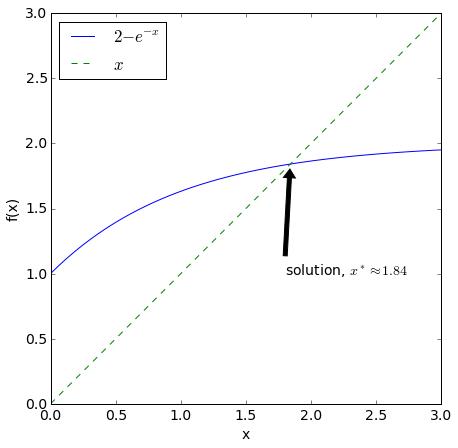

In [19]:
def f(x):
    '''Calculates a simple mathematic function from Newman 6.3.1
    
    It is written using numpy's exponential function (not math) so it can operate on numpy arrays.
    accepts: x - float
    returns f(x) - float
    '''
    
    return 2 - np.exp(-x)

#define the x-range
x = np.linspace(0,3)

#set up the plot
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

#plot the function - both left hand side and right hand side
ax.plot(x,f(x),label=r"$2-e^{-x}$")
ax.plot(x,x,label=r"$x$",ls='--')

#add good labels
ax.legend(loc='best')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_aspect('equal')

#add a label to be extra transparent
text1 = ax.annotate(r'solution, $x^* \approx 1.84$', xy=(1.84, 1.84), xytext=(1.8, 1.0),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

*Notice how I added an arrow and text to the figure above?  This is very useful.*

### Solve the equation $x=2-e^{-x}$ as in Newman, and include a measure of the error at each step.

In [37]:
x = 1.0
for k in range (10):
    xOld = x
    x = 2-np.exp(-x)
    error = (x-xOld)
    print("x Values:", x, "Error:", error)


x Values: 1.63212055883 Error: 0.632120558829
x Values: 1.80448546585 Error: 0.172364907019
x Values: 1.83544089392 Error: 0.0309554280746
x Values: 1.84045685534 Error: 0.00501596142149
x Values: 1.84125511391 Error: 0.000798258567897
x Values: 1.84138178281 Error: 0.000126668901436
x Values: 1.84140187354 Error: 2.00907228571e-05
x Values: 1.84140505985 Error: 3.18631899665e-06
x Values: 1.84140556519 Error: 5.05333265455e-07
x Values: 1.84140564533 Error: 8.01430233288e-08


#### Prove mathematically that the Relaxation Method will work on the function above.  Show your work and briefly explain

<div class=answer>
<div/>
The difference between the calcualted value and the actual value becomes smaller by a factor of f'(x*) at each iteration. So f'(x*) must be less than 1.

In [24]:
math.exp(-1.8414)

0.1585952372788415

## Exercise 2

### Newman's Exercise 6.10: The percolation transition

Consider the equation $x = 1 - \ e^{-cx}$, where $c$ is a known parameter and $x$ is unknown.  This equation arises in a variety of situations, including the physics of contact processes, mathematical models of epidemics, and the theory of random graphs.

####  First plot the function for the case $c=2$.  
Mark both the trivial solution and the (approximate) non-trivial solution. 

**Lab-like exercise: **
Write a full description of your plots for this section, as if you were in lab.  While it might not be so clear why this is named *the percolation transition* hopefully it is very clear why this is called *the epidemic threshold*.  Please include some insights related to this name in your description of these plots.

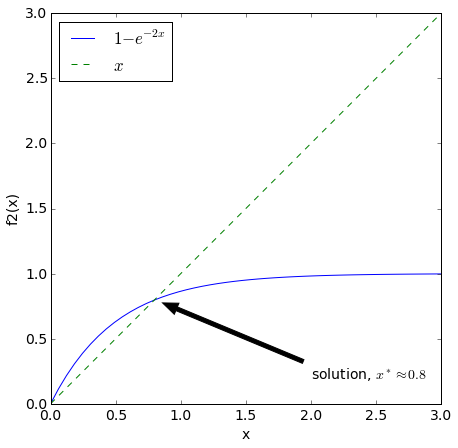

In [35]:
def f2(x, c):
    '''Calculates a simple mathematic function from Newman 6.3.1
    
    It is written using numpy's exponential function (not math) so it can operate on numpy arrays.
    accepts: x - float
    returns f(x) - float
    '''
    
    return 1 - np.exp(-c*x)

#define the x-range
x = np.linspace(0,3)

#set up the plot
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

#plot the function - both left hand side and right hand side
ax.plot(x,f2(x, 2),label=r"$1-e^{-2x}$")
ax.plot(x,x,label=r"$x$",ls='--')

#add good labels
ax.legend(loc='best')
ax.set_xlabel('x')
ax.set_ylabel('f2(x)')
ax.set_aspect('equal')

#add a label to be extra transparent
text1 = ax.annotate(r'solution, $x^* \approx 0.8$', xy=(0.8, 0.8), xytext=(2.0, 0.2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

#### Write a program to solve this equation for $x$ using the relaxation method for the case $c=2$.  
Calculate your solution to an accuracy of at least $10^{-6}$.

In [63]:
def relax(f,*args,tol = 1e-6):
    x = 1.0
    error = 2*tol
    while abs(error) >= abs(tol):
        xOld = x
        x = f(x,*args)
        error = (x-xOld)
        print("x Values:", x, "Error:", error)

relax(f2, 2, tol = 1e-6)

x Values: 0.864664716763 Error: -0.135335283237
x Values: 0.822596669181 Error: -0.0420680475825
x Values: 0.807024750332 Error: -0.0155719188491
x Values: 0.800920194237 Error: -0.00610455609513
x Values: 0.798474708325 Error: -0.00244548591188
x Values: 0.797486639463 Error: -0.00098806886216
x Values: 0.797086049491 Error: -0.000400589971551
x Values: 0.796923413762 Error: -0.000162635728866
x Values: 0.796857348001 Error: -6.60657613076e-05
x Values: 0.79683050468 Error: -2.68433213021e-05
x Values: 0.796819596899 Error: -1.09077808818e-05
x Values: 0.796815164356 Error: -4.43254298199e-06
x Values: 0.796813363097 Error: -1.80125901883e-06
x Values: 0.796812631112 Error: -7.31984842961e-07


#### Modify your program to calculate the solution for values of $c$ from 0 to 3 in steps of 0.01 and make a plot of $x$ as a function of $c$.  
   
   You should see a clear transition from a regime in which $x=0$ to a regime of nonzero $x$.   This is another example of a phase transition.   In physics this transition is known as the *percolation transition*;   in epidemiology it is the *epidemic threshold*.

In [64]:
for i in np.linspace (0,3,0.01):
    relax(f2, i)

<div class=answer>
<div/>
Describe your plot here.

## Exercise 3: Benchmark function for rootfinding
You will use the function
$$
f(x)=\cos x - x
$$

as a benchmark  in developing the following routines.  To orient yourself, first make a plot of the benchmark function. You will want to plot it over a
reasonably wide range, *e.g.*, $-10\leq x \leq 10$, since you will be playing with different choices of initial intervals and guess points in this range.


In [4]:
#your plot here

#include the following line so you can see where your function crosses zero.
#ax.axhline(y=0,ls='--',color='gray')

## Exercise 4 - introduction to bisection

For efficiency, I have provided a basic code on the bisection method.  Read the code below carefully and check that it is written as you would expect.

The bisection method is our baseline method, to which we will be
comparing the other new members.  Moreover, we will be using bisection
steps when we "hybridize" the bisection method with the other, more
sophisticated rootfinding methods.  So, let us start off our new
rootfind methods by bundling the code above into a function.  

Take a close look, and make sure you understand the logic.  The loop structure is designed to provide a better starting point for the approach we will need to take with in the other rootfinding methods.

For instance, all these other methods are based on the idea of finding successive approximations $x_i$ ($i=0$, $1$, $2$, $\ldots$).  Then the "error" is estimated the difference between the two most recent approximate roots, *i.e.*,
$$
\epsilon_i = x_i - x_{i-1}.
$$

In [5]:
""" rootfind.py -- library of rootfinding routines
     
    Language: Python 3
    Mark A. Caprio
    University of Notre Dame
    Written for Computational Methods in Physics, Spring 2014.
"""

def bisection(f,interval,tolerance,verbose=False):
    """ Find root by bisection.

    The 'approximation' x_i at each iteration is defined by the
    midpoint of the interval.
    
    The 'error' x_i-x_(i-1) is defined by the change in midpoint from
    the midpoint of the last interval.  (Of course, for bisection,
    that is always half the width of the new interval.)

    Returns None if the sign of the function does not change on the
    given interval.  Otherwise, returns final midpoint x_i when
    termination condition is reached.

    f: function for rootfinding
    interval: tuple containing initial interval endpoints (xa,xb)
    tolerance: difference x_i-x_(i-1) at which search should terminate
    verbose (optional): whether or not to print iteration log
    """

    # set up initial bracketing interval
    #   Note: Sign of function *must* change in this interval for method to work.
    (xa,xb) = interval
    fxa = f(xa)
    fxb = f(xb)
    if (fxa*fxb >=0):
        # no sign change in interval
        return None

    # set up for first iteration
    xm = (xb + xa)/2
    error = (xb - xa)/2
    iteration_count = 0

    # bisect until tolerance reached
    while (abs(error) > tolerance):

        # increment iteration count
        iteration_count += 1
        
        # evaluate function
        fxa = f(xa)
        fxb = f(xb)
        fxm = f(xm)

        # find which subinterval contains root
        if (fxm == 0):
            # accidentally landed on root (often occurs for "toy" test intervals)
            xa = xm
            xb = xm
        elif ((fxa * fxm) < 0):
            # sign change is in left half of interval
            xb = xm
        else:
            # sign change is in right half of interval
            xa = xm

        # find new midpoint (and change in midpoint)
        xm_old = xm
        xm = (xb + xa)/2
        error = xm - xm_old

        # verbose iteration log
        if (verbose):
            print("iteration", iteration_count, "(bisection):",
                  "interval", (xa, xb), "root", xm)
            
    return xm

 When this estimated error falls below the tolerance, we terminate and return the "last guess" $x_i$.  We can think about the bisection method somewhat the same way (at least, we can phrase the termination condition and return value the same way) if we think of the "midpoint" of our interval as $x_i$.  
 
 **See the usage example below:**

In [ ]:
# test code
if (__name__ == "__main__"):

    # read in external libraries
    import math

    # define function for rootfinding
    def f_bench(x):
        return math.cos(x) - x
    def fp_bench(x):
        return -math.sin(x) - 1

    # bisection tests

    print("bisection(f_bench,(-1,0),1e-10,verbose=True)")
    print(bisection(f_bench,(-1,0),1e-10,verbose=True))

    print("bisection(f_bench,(0,1),1e-10,verbose=True)")
    print(bisection(f_bench,(0,1),1e-10,verbose=True))

If the tolerance is $10^{-3}$, how many bisections do you expect to need?  What if the tolerance is $10^{-6}$ ?  Or $10^{-9}$ ?  Try this out, and record the number of iteration and the approximate root (or, rather, root-containing interval) you find in each case, for $\cos x - x$.
 
 *Hint:* An incredibly-convenient almost-equality is $2^{10} = 1024 \approx 1000 = 10^3$.  Remember this.  Forever.  This is why 1024 bytes make a "kilobyte" to a computer scientist.

In [3]:
#your code here

<div class=answer>
<div/>
Answer here

Try ```bisection``` out on the benchmark function, using the interval $(0,1)$ and a tolerance $10^{-10}$.  How many iterations are required? 

In [ ]:
#your code here

<div class=answer>
<div/>
Answer here

What happens if you ask for a tolerance of $10^{-21}$?  Does it take as many iterations as you expect?  Do you get what you asked for?  Explain roughly what is going on. 

In [3]:
#your code here

<div class=answer>
<div/>
Answer here

What happens if you use the interval $(-1,0)$, and why?

<div class=answer>
<div/>
Answer here

## Exercise 5: Wien's Displacement Constant
Work out Newman's 6.13 **in a lab format**.  As in the percolation problem, 
* plot and label the numerical function you are trying to solve before "cranking away."  
* write a thoughtful description about each plot
* take note of the tolerance you choose and the number of steps required to solve.

You may use the scipy constants library if you like:
https://docs.scipy.org/doc/scipy/reference/constants.html

In [3]:
from scipy.constants import c
print(c)

#or even better, remember to track where your functions come from:
from scipy import constants as const
print(const.c)

299792458.0
299792458.0


In [ ]:
#insert code and markdown cells as needed

## Exercise 6: Newton-Raphson method

Now let us go ahead and code a function to implement the Newton-Raphson method.  I have gotten us started by defining the interface:

In [ ]:
def newton(f,fp,x_guess,tolerance,verbose=False,max_iterations=100):
    """ Find root by Newton's method.

    The 'approximation' x_i at each iteration is defined by Newton's
    method, in terms of the previous approximation x_(i-1).
    
    The 'error' x_i-x_(i-1) is defined by the difference in successive
    approximations.

    Returns None if the maximum number of iterations is reached
    without satisfying the tolerance.  Also returns None if
    rootfinding lands on point where f has zero slope.  Otherwise,
    returns final approximation x_i when termination condition is
    reached.

    f: function for rootfinding
    fp: derivative of function for rootfinding (i.e., 'f prime')
    x_guess: initial guess point
    tolerance: error at which search should terminate
    verbose (optional): whether or not to print iteration log
    max_iterations (optional): limit on number of iterations
    """

    # set up for first iteration
    x = x_guess
    error = 2*tolerance  # set error big enough to get past while condition
    iteration_count = 0

    # TODO

    return x


Notice that, in case of complete failure, we should put in a maximum number of iterations as a "safety net", to avoid an infinite loop.

Try your function out on our benchmark function, picking starting points reasonably near the root.  Actually, when it comes time to print out a test case to hand in, please use $x_0=0.5$.

Now, we probably thought of bisection as being pretty "fast" as a way to get to the root.  After all, we saw in **Exercise 3** the error in the bisection method falls exponentially with the number of iterations
$$
\epsilon_i \propto \frac{1}{2^i}.
$$
And "exponential" is "fast", right?  But from Newman you have seen that we expect the Newton-Raphson method to be even faster, at least, once we have gotten close enough to a root that the function is basically described by the first couple of terms in its Taylor series around that root.
 
So let us actually compare the performance of ```bisect``` and ```newton```.  We have already run the necessary test cases.  For ```bisect```, we started with the initial interval $(0,1)$, and, for ```newton```, 
we used $x_0=0.5$, which is the midpoint of this interval.  So it seems reasonable to compare these test cases.  Based on your log of iterations (from the verbose output) make a table indicating how many how many digits of
the answer $x_i$ are correct, with each method, after each iteration ($i=0$, $1$, $2$, $\ldots$).

In [ ]:
#your code here

<div class=answer>
<div/>
Answer here

For the *bisection* method, does the growth in the number of correct digits look linear in the number of iterations, or perhaps quadratic, or exponential?  How about for the *Newton-Raphson* method (the trend here may be
harder to judge by eye)?  Explain these results in terms of the expected convergence rates (from Newman).

<div class=answer>
<div/>
Answer here

What happens if you start Newton's method instead with the initial guess point $x=5$?  How about $x=10$?  Explain what's going on.  It will help to look back at your plot of this function.  

<div class=answer>
<div/>
Answer here

## Exercise 7: More on Newton's method

Here's one more illustration with Newton's method.  Let's try it out on the function

$$
\begin{equation}
f(x)=x^2+1.
\end{equation}
$$

What happens if you pick $x=0$ as the starting point?  How about
$x=0.5$?

In [ ]:
#your code here

<div class=answer>
<div/>
Answer here

*Comment:* Notice that we were applying a rootfinding method, to a function which
had no root. A physics professor of mine promulgated this bit of wisdom:

    **First rule: Think before you try cranking away!**

But, even if we were immune to being so silly as to ever attempt this, there is
a lesson to be learned.  What if our function *had* a root, off somewhere far away from the initial guess point, but the guess point landed us near a local minimum in the function?  Our function would locally look just like this parabola, and the Newton-Raphson method could become trapped oscillating around the minimum, in just this fashion.

**Summary:** Here is an attempt at summarizing the lessons we have learned.  When it works, Newton-Raphson converges much more rapidly than bisection.  However, sometimes it jumps around before converging.  Sometimes it just oscillates, without converging.  Or, if the starting point is not close enough to a root, the method may go
completely astray.

**When it's good, it's very, very good.  When it's bad, it's horrid.**

## Exericise 8 - The Lagrange Point.  
Work out Newman's Exercise 6.16 below **in a lab format**.  As in the percolation problem, 
* plot and label the numerical function you are trying to solve before "cranking away."  
* write a thoughtful description about each plot
* take note of the tolerance you choose and the number of steps required to solve.

You can use the astropy version of the constants library, you may have to install astropy to use them, but I did not
http://docs.astropy.org/en/stable/constants/

In [10]:
from astropy import constants as a_const

print(const.G)
print("Note that you can do arithmetic with the 'Value': 5*G =")
print(const.G*5)



  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
Note that you can do arithmetic with the 'Value': 5*G =
3.3370400000000003e-10 m3 / (kg s2)
